# Kaggle : Predict Future Sales 커널 필사 리뷰

***

> Week4_Regression : time-series regression 시계열  

- 대회 소개

    + 비즈니스 소프트웨어 기업 1c company의 일별 판매 내역 데이터가 제공됨

    + 다음 달 해당 스토어에서 판매되는 제품량 예측

    + 상점 및 제품 목록은 매월 약간씩 변경되며 이러한 상황을 처리할 수 있는 강력한 만들자.


- 데이터 파일
    + sales_train.csv - **2013년 1월부터 2015년 10월**까지의 일일 과거 데이터.  train set
    + test.csv - 상점과 제품의 **2015년 11월 판매량** 을 예측 test set. 
    + sample_submission.csv - 제출 파일
    + items.csv - 항목/제품에 대한 추가 정보.
    + item_categories.csv  - 항목/제품 카테고리에 대한 추가 정보.
    + shops.csv- 상점에 대한 추가 정보

- 추가 커널 
    + https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts
    + https://www.kaggle.com/dimitreoliveira/time-series-forecasting-with-lstm-autoencoders/notebook

---





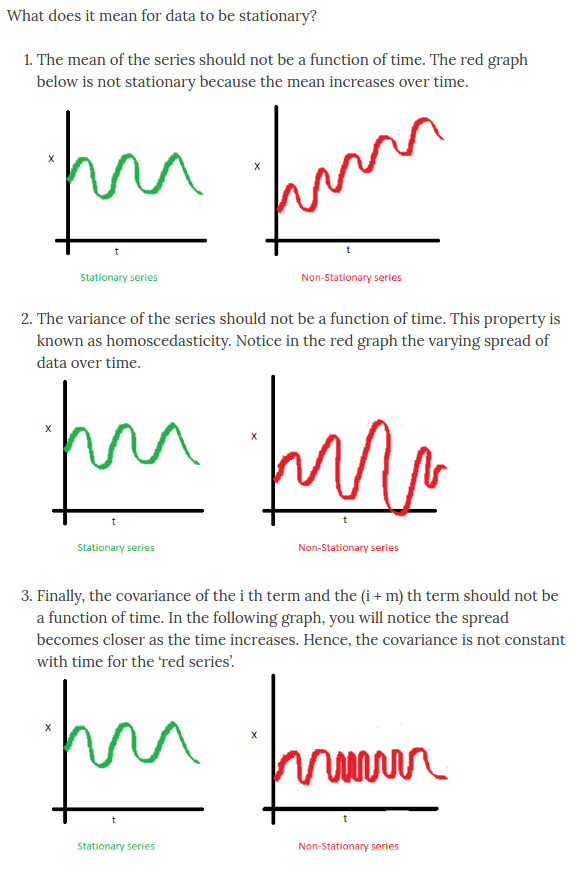

## 패키지 설치 및 데이터 로드

### 패키지 설치

In [ ]:
# 패키지 설치
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# settings : 결과로 바로 그림이 나오도록 + 스타일 서식
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
sns.set(style="darkgrid") 
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

### 데이터 불러오기

In [ ]:
# 제공하는 데이터 셋 모두 불러오기
from google.colab import drive
drive.mount('/content/drive')

In [3]:
sales = pd.read_csv('/content/drive/MyDrive/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
test = pd.read_csv('/content/drive/MyDrive/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32','item_id': 'int32'})
items = pd.read_csv('/content/drive/MyDrive/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})
item_categories = pd.read_csv('/content/drive/MyDrive/item_categories.csv', dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
shops = pd.read_csv('/content/drive/MyDrive/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})

In [82]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1
1,2013-03-01,0,25,2552,899.00,1
2,2013-05-01,0,25,2552,899.00,-1
3,2013-06-01,0,25,2554,1709.05,1
4,2013-01-15,0,25,2555,1099.00,1


In [ ]:
items.head()

In [ ]:
item_categories.head()

In [ ]:
shops.head()

### Join 조인

In [4]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [119]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935848.00,2935848.00,2935848.00,2935848.00,2935848.00,2935848.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,0.07,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00



> feature 
- ID 
- shop_id 
- item_id 
- item_category_id 
- item_cnt_day - 하루에 판매된 제품 수 **[target]** -> 한달에 판매된 제품 수
- item_price - 제품의 현재 가격
- date - 날짜 (포맷 형식) : dd/mm/yyyy
- date_block_num - 편의를 위한 월 번호. 2013년 1월 :0,  2013년 2월 :1,,,,,,,, 2015년 10월: 33
- item_name - 제품 이름
- shop_name - 가게 이름
- item_category_name - 제품 카테고리 이름

## 전처리

## Data Leakage 통제
- data leakage : training 데이터 밖에서 유입된 정보들로 인한 과적합 문제
- test set에 존재하는  `shop_id` , `item_id` 만 사용

In [5]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# test set에만 있는 shop_id
lk_train = train[train['shop_id'].isin(test_shop_ids)]
# test set에만 있는 item_id
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [6]:
print('Data set size before leaking:', train.shape[0]) #293만
print('Data set size after leaking:', lk_train.shape[0]) #122만

Data set size before leaking: 2935849
Data set size after leaking: 1224439


In [92]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


## Data Cleaning

### 가격 조정

In [7]:
# 제품 가격 음수값 제거
train = train.query('item_price > 0') #가격 음수값 제거

### 사용할 피쳐 선택

In [8]:
# 필요한 열 선택 -  제품명, 가게명 제거
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

### month 기준으로 aggregate 

In [9]:
# month 기준으로 aggregate 
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

In [10]:
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
train_monthly.head() 

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.00,1532.86,9,1.29,7
1,0,2,2,5643,4775.21,2387.60,0,0.00,2
2,0,2,5,5583,1188.30,594.15,2,1.00,2
3,0,2,6,7893,5970.00,1990.00,3,1.00,3
4,0,2,6,7894,1490.00,1490.00,1,1.00,1


###  missing record 생성

In [11]:
# missing record 생성
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

# 합치기
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [151]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.00,16.50,9.81,0.00,8.00,16.50,25.00,33.00
shop_id,6734448.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,6734448.00,11041.89,6210.74,30.00,5385.25,11265.50,16068.25,22167.00
item_category_id,6734448.00,3.79,13.21,0.00,0.00,0.00,0.00,83.00
item_price,6734448.00,187.35,2171.80,0.00,0.00,0.00,0.00,515573.59
mean_item_price,6734448.00,81.13,531.16,0.00,0.00,0.00,0.00,42990.00
item_cnt,6734448.00,0.24,3.46,-4.00,0.00,0.00,0.00,2253.00
mean_item_cnt,6734448.00,0.10,0.61,-2.00,0.00,0.00,0.00,1000.00
transactions,6734448.00,0.18,0.90,0.00,0.00,0.00,0.00,31.00


### 시간  변수 추가 생성 : year, *month*

In [12]:
# 시간 변수 추가 생성
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

### outlier 제거 

In [13]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

## EDA

In [110]:
# 그룹화
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

>  월별 판매 동향 : trending increase of item sales count (mean) towards the ending of the year.

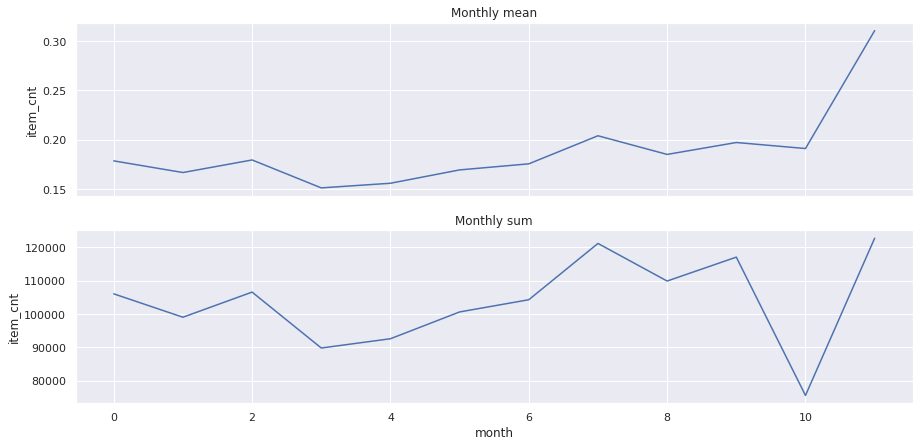

In [111]:
f, axes = plt.subplots(2, 1, figsize=(15, 7), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

> 카테고리 별 판매 동향 : only few of the categories seems to hold most of the sell count.

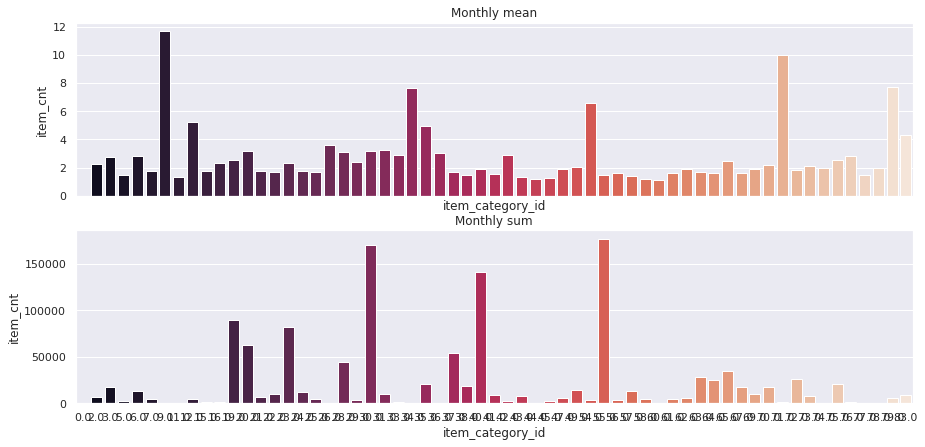

In [112]:
f, axes = plt.subplots(2, 1, figsize=(15,7), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

> 가게 별 동향 : 3-4 of them have a much higher rate

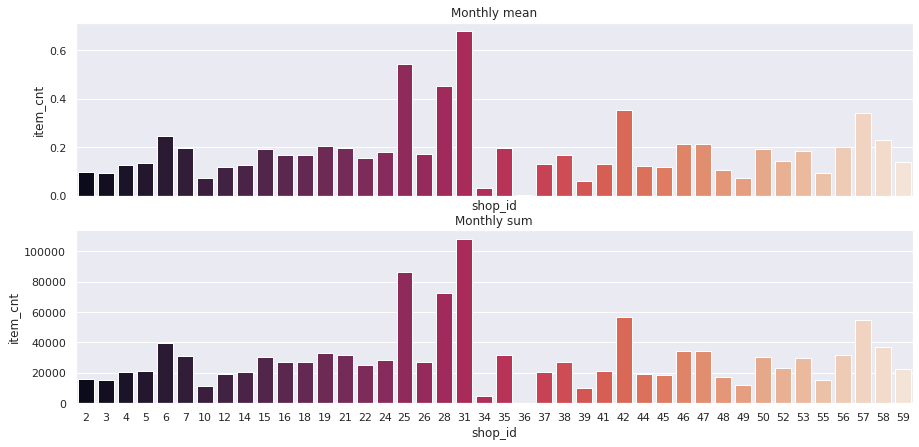

In [113]:
f, axes = plt.subplots(2, 1, figsize=(15,7), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

### 피쳐 엔지니어링



In [14]:
# LABEL 생성 : month 별 제품수(item_cnt)의 합
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1) #다음 달 판매량

In [15]:
# min, max 가격 추가
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

In [16]:
# 증가분, 감소분 추가
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

### rolling

In [17]:
# Rolling  (window = 3달).
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

### lag

In [18]:
# lag
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

### trend 반영

In [19]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

In [20]:
train_monthly.describe()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
count,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6530047.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00
mean,16.50,31.64,11042.87,3.75,169.77,79.71,0.19,0.09,0.17,2013.94,5.21,0.19,0.00,5561.39,169.77,5396.74,0.14,0.26,0.20,0.07,0.16,0.14,0.13,-0.06
std,9.81,17.56,6209.70,13.16,1792.01,522.27,0.91,0.31,0.74,0.80,3.32,0.91,0.00,11482.78,1792.01,11022.27,0.69,1.25,0.92,0.44,0.88,0.85,0.82,0.44
min,0.00,2.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-12.50
25%,8.00,16.00,5386.00,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,2.00,0.00,0.00,1043.00,0.00,999.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,16.00,35.00,11266.00,0.00,0.00,0.00,0.00,0.00,0.00,2014.00,5.00,0.00,0.00,2408.00,0.00,2396.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,25.00,47.00,16068.00,0.00,0.00,0.00,0.00,0.00,0.00,2015.00,8.00,0.00,0.00,5592.00,0.00,5490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,33.00,59.00,22167.00,83.00,366860.00,42990.00,20.00,20.00,19.00,2015.00,11.00,20.00,0.00,366860.00,366860.00,366860.00,20.00,20.00,20.00,13.44,20.00,20.00,20.00,5.00


In [21]:
train_monthly_p = train_monthly.copy()

## Train/validation split
- train set : block_num(3~28), 
- validation set : block_num(29~32) 
- test : block_num (33)

In [22]:
train_set = train_monthly_p.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly_p.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly_p.query('date_block_num == 33').copy()

#타겟 변수는 제외
train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly_p.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly_p.shape[0])*100)))

Train set records: 4946785
Validation set records: 989412
Test set records: 197879
Train set records: 4946785 (74% of complete data)
Validation set records: 989412 (15% of complete data)


## Mean Encoding


In [ ]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [51]:
train_set.describe()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean_x,item_mean_x,shop_item_mean_x,year_mean_x,month_mean_x,shop_mean_y,item_mean_y,shop_item_mean_y,year_mean_y,month_mean_y
count,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00,4946785.00
mean,15.00,31.64,11042.90,3.54,164.66,72.25,0.18,0.09,0.16,2013.80,5.40,0.19,0.00,5589.07,164.66,5424.78,0.14,0.26,0.19,0.07,0.16,0.14,0.13,-0.06,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
std,7.21,17.56,6209.50,12.80,1888.58,463.65,0.92,0.31,0.75,0.69,3.42,0.93,0.00,11565.01,1888.58,11083.17,0.69,1.28,0.93,0.45,0.91,0.88,0.85,0.45,0.13,0.41,0.55,0.04,0.04,0.13,0.41,0.55,0.04,0.04
min,3.00,2.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-12.50,0.00,0.00,0.00,0.14,0.14,0.00,0.00,0.00,0.14,0.14
25%,9.00,16.00,5386.00,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,3.00,0.00,0.00,1043.00,0.00,999.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.14,0.16,0.12,0.00,0.00,0.14,0.16
50%,15.00,35.00,11266.00,0.00,0.00,0.00,0.00,0.00,0.00,2014.00,5.00,0.00,0.00,2408.00,0.00,2396.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.05,0.00,0.21,0.17,0.17,0.05,0.00,0.21,0.17
75%,21.00,47.00,16068.00,0.00,0.00,0.00,0.00,0.00,0.00,2014.00,8.00,0.00,0.00,5592.00,0.00,5495.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.20,0.16,0.21,0.20,0.20,0.20,0.16,0.21,0.20
max,27.00,59.00,22167.00,83.00,366860.00,33490.00,20.00,19.00,19.00,2015.00,11.00,20.00,0.00,366860.00,366860.00,366860.00,20.00,20.00,20.00,13.44,20.00,20.00,20.00,5.00,0.68,6.97,20.00,0.22,0.32,0.68,6.97,20.00,0.22,0.32


### X_train, Y_train, X_validation, Y_validation

In [32]:
# X_train, Y_train, X_validation, Y_validation
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [33]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

### X_test

In [35]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])

X_test['year'] = 2015
X_test['month'] = 9  # 다음 달 예측 상태로 만들어뒀으니 9월 입력
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]



In [36]:
sets = [X_train, X_validation, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
# for dataset in sets:
#     for item_id in dataset['item_id'].unique():
#         for column in dataset.columns:
#             item_median = dataset[(dataset['item_id'] == item_id)][column].median()
#             dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [37]:
# drop item_Category_id
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [42]:
X_train.to_csv('/content/drive/MyDrive/X_train',index=None)
X_validation.to_csv('/content/drive/MyDrive/X_validation',index=None)
X_test.to_csv('/content/drive/MyDrive/X_test',index=None)

In [49]:
Y_train.to_csv('/content/drive/MyDrive/Y_train',index=None)
Y_validation.to_csv('/content/drive/MyDrive/Y_validation',index=None)
Y_test.to_csv('/content/drive/MyDrive/Y_test',index=None)